# Predicting Heart Disease using K-nearest Neighbours
The [World Health Organization (WHO)](https://www.who.int/health-topics/cardiovascular-diseases) estimates that `17.9 million` people die from **cardiovascular diseases (CVDs)** every year.

There are multiple risk factors that could contribute to CVD in an individual, such as **unhealthy diet, lack of physical activity, or mental illness**. Identifying these risk factors early on could help prevent many premature deaths.

## The Task
We are working for an R&D company that focuses on providing healthcare solutions. We are tasked with **using dataset to accurately predict the likelihood of a new patient having heart disease in the future**.

## The dataset
The company has collected anonymized data from multiple hospitals on several patients. The [dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) includes relevant information for each patient, such as their personal information and some medical data, including **whether or not they have had heart disease before**.

## Load and Analyse the data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('heart_disease_prediction.csv')
print(data.shape)
data.head()

(918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


The dataset has 918 rows or observations and 12 columns (**11 features** and **1 target or label**) as follows :

* **Age**: age of the patient (years)
* **Sex**: sex of the patient (M: Male, F: Female)
* **ChestPainType**: chest pain type (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic)
* **RestingBP**: resting blood pressure (mm Hg)
* **Cholesterol**: serum cholesterol (mm/dl)
* **FastingBS**: fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise)
* **RestingECG**: resting electrocardiogram results (Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria)
* **MaxHR**: maximum heart rate achieved (Numeric value between 60 and 202)
* **ExerciseAngina**: exercise-induced angina (Y: Yes, N: No)
* **Oldpeak:** oldpeak = ST (Numeric value measured in depression)
* **ST_Slope**: the slope of the peak exercise ST segment (Up: upsloping, Flat: flat, Down: downsloping)
* **HeartDisease**: output class (1: heart disease, 0: Normal)

### Checking for missing data and data types of the features

In [3]:
z = data.isnull().sum()
print(f'Columns with missing values:\n{z[z > 0]}')

Columns with missing values:
Series([], dtype: int64)


In [4]:
print(data.dtypes)

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


### NOTE
The columns **FastingBS** and **HeartDisease** are **categorical types** by nature despite the fact that they are coded as integers.
### Some Descriptive Statistics

In [5]:
print(list(data))

['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


In [6]:
cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
data[cols].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


### Some Observations
* The mean age of the patients is 53 years
* The youngest patient is 28 years
* The oldest patient is 77 years

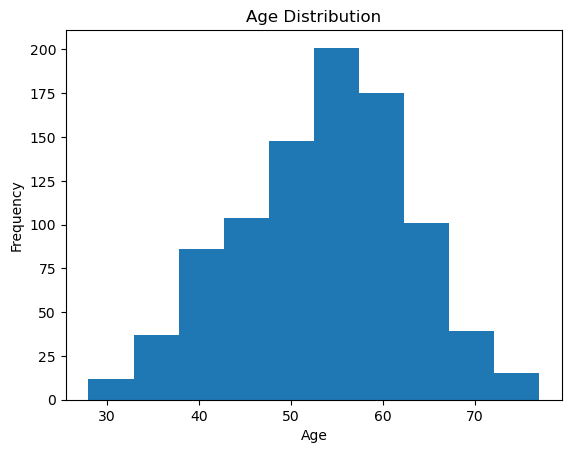

In [7]:
data.Age.plot.hist()
plt.title('Age Distribution')
plt.xlabel('Age');

In [8]:
heart_disease_count = data.HeartDisease.value_counts()
heart_disease_count

HeartDisease
1    508
0    410
Name: count, dtype: int64

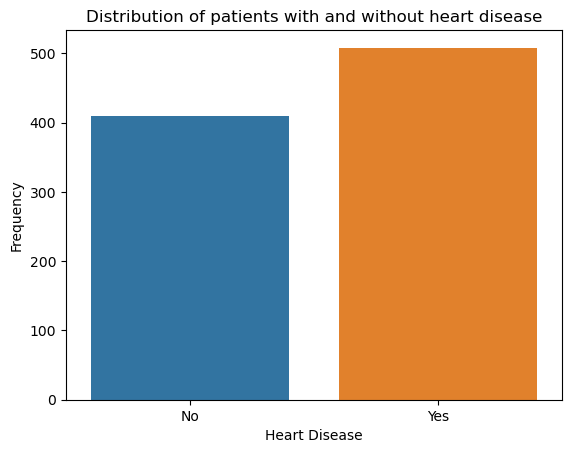

In [9]:
import warnings
warnings.filterwarnings('ignore')

#data.HeartDisease.value_counts().plot.bar()
sns.barplot(x = heart_disease_count.index, y = heart_disease_count.values)
plt.title('Distribution of patients with and without heart disease')
plt.xlabel('Heart Disease')
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylabel('Frequency');

We are dealing with a relatively balanced dataset with no huge difference between the number of patients with heart disease and those without heart disease.
### Relationship between Cholesterol and Age

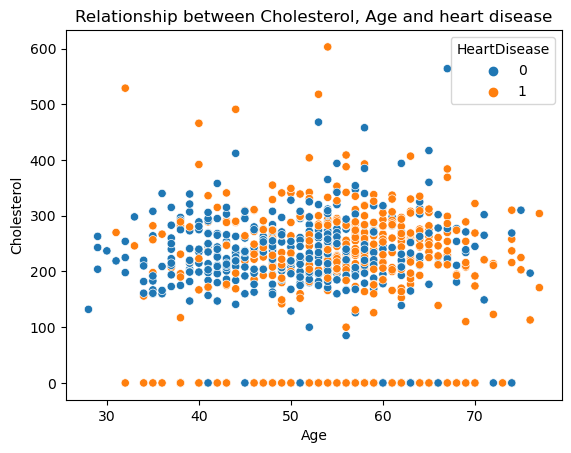

In [10]:
sns.scatterplot(x = 'Age', y = 'Cholesterol', hue = 'HeartDisease', data = data)
plt.title('Relationship between Cholesterol, Age and heart disease');

* It can be seen that those with high Cholesterol levels generally have high risk of having a heart disease.
* Similarly, from the age of about 50 most people are highly likely to develop heart disease.

### Some Questions
* Could `RestingBP` (resting blood pressure) have a value of zero? 

* What about `Cholesterol`? Low cholesterol certainly sounds like a good thing, but can it be zero? Certainly not!

In [11]:
gender_count = data.Sex.value_counts()
gender_count

Sex
M    725
F    193
Name: count, dtype: int64

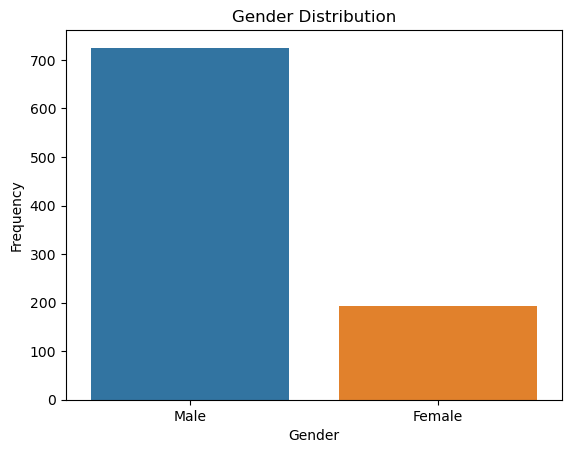

In [12]:
sns.barplot(x = gender_count.index, y = gender_count.values)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.xticks([0, 1], ['Male', 'Female'])
plt.ylabel('Frequency');

The dataset is highly skewed or imbalanced towards male patients with **`725`** rows correspond to male patients, whereas only **`193`** correspond to female patients. This could potentially induce a bias in our classification model and negatively impact predictions for any female patients in any unseen data.

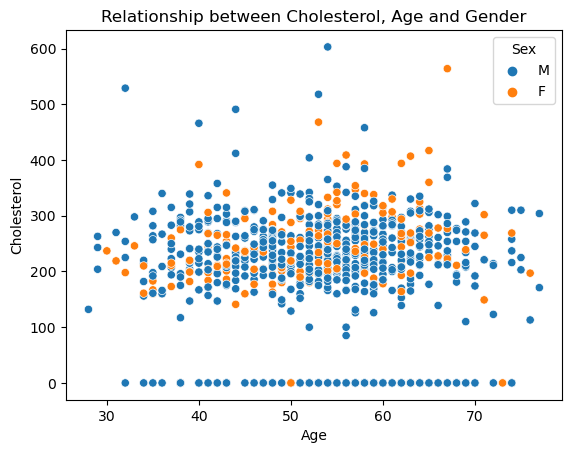

In [13]:
sns.scatterplot(x = 'Age', y = 'Cholesterol', hue = 'Sex', data = data)
plt.title('Relationship between Cholesterol, Age and Gender');

The dataset is biased towards the male gender and as such the plot above show any imformative trend in Cholesterol level with gender.

In [14]:
FastingBS_count = data.FastingBS.value_counts()
FastingBS_count

FastingBS
0    704
1    214
Name: count, dtype: int64

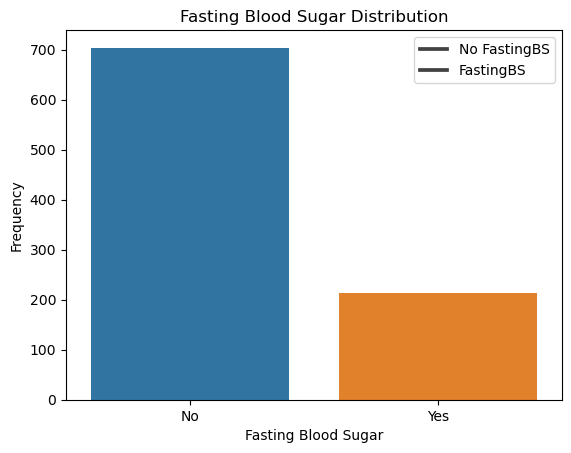

In [15]:
sns.barplot(x = FastingBS_count.index, y = FastingBS_count.values)
plt.title('Fasting Blood Sugar Distribution')
plt.xlabel('Fasting Blood Sugar')
plt.xticks([0, 1], ['No', 'Yes'])
plt.legend(labels = ['No FastingBS', 'FastingBS'])
plt.ylabel('Frequency');

In [16]:
ChestPainType_count = data.ChestPainType.value_counts()
ChestPainType_count

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

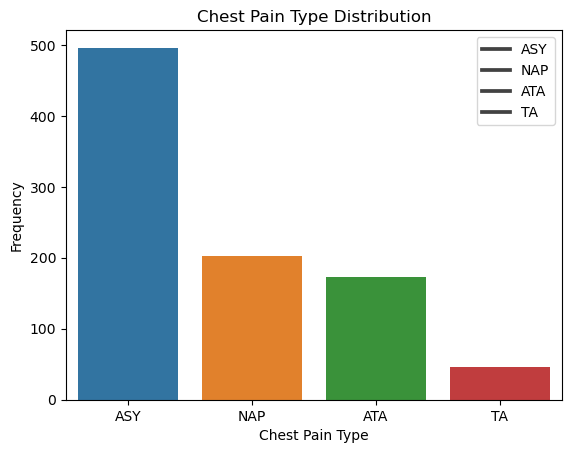

In [17]:
sns.barplot(x = ChestPainType_count.index, y = ChestPainType_count.values)
plt.title('Chest Pain Type Distribution')
plt.xlabel('Chest Pain Type')
plt.gca().legend(('ASY', 'NAP', 'ATA', 'TA'))
plt.ylabel('Frequency');

### More stats...
* Percentage of patients with heart disease are male and over 50 years old
* Median age of patients who were diagnosed with heart disease

In [18]:
mask = (data.Age > 50) & (data.Sex == 'M') & (data.HeartDisease == 1)
pct = len(data.loc[mask]) / len(data)
print(f'Percentage of male patients over 50 years with heart disease: {pct: .2f}%')

Percentage of male patients over 50 years with heart disease:  0.37%


In [19]:
hd_stats = data.loc[data.HeartDisease == 1, 'Age'].describe()
hd_stats

count    508.000000
mean      55.899606
std        8.727056
min       31.000000
25%       51.000000
50%       57.000000
75%       62.000000
max       77.000000
Name: Age, dtype: float64

In [20]:
print(f'The mean age of patients with heart disease: {hd_stats["mean"]: .0f}')
print(f'The median age of patients with heart disease: {hd_stats["50%"]: .0f}')
print(f'The oldest patient with heart disease: {hd_stats["max"]: .0f}')
print(f'The youngest patient with heart disease: {hd_stats["min"]: .0f}')

The mean age of patients with heart disease:  56
The median age of patients with heart disease:  57
The oldest patient with heart disease:  77
The youngest patient with heart disease:  31


## Data Cleaning
It's time to address these two situations:

* Could `RestingBP` (resting blood pressure) have a value of zero? 

* What about `Cholesterol`? Low cholesterol certainly sounds like a good thing, but can it be zero? Certainly not!

We could do one of the following:

* remove those rows entirely if their frequency of occurrence is low.
* impute or replace those zeros with the median value of that column or the median value of the column grouped by **HeartDisease**.
* apply some other imputation techniques


In [21]:
print(f'No. of rows with 0 value (RestingBP): {sum(data.RestingBP == 0)}')
print(f'No. of rows with 0 value (Cholesterol): {sum(data.Cholesterol == 0)}')

No. of rows with 0 value (RestingBP): 1
No. of rows with 0 value (Cholesterol): 172


#### Imputing zero values using column median

In [22]:
data['RestingBP'] = data.RestingBP.apply(lambda x: x or np.median(data.RestingBP))
data['Cholesterol'] = data.Cholesterol.apply(lambda x: x or np.median(data.Cholesterol))

In [23]:
print(f'No. of rows with 0 value (RestingBP): {sum(data.RestingBP == 0)}')
print(f'No. of rows with 0 value (Cholesterol): {sum(data.Cholesterol == 0)}')

No. of rows with 0 value (RestingBP): 0
No. of rows with 0 value (Cholesterol): 0


## Feature Selection
### Transforming Categorical features to dummies

In [24]:
 df = pd.get_dummies(data, drop_first = True)

In [25]:
correlations = df.corr().abs()
correlations

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
Age,1.000000,0.263054,0.030979,0.198039,0.382045,0.258612,0.282039,0.055750,0.218165,0.011335,0.032042,0.230566,0.136798,0.215793,0.185568,0.258067
RestingBP,0.263054,1.000000,0.090835,0.067896,0.109771,0.174130,0.117798,0.009346,0.051293,0.027772,0.049498,0.113842,0.089219,0.153133,0.109956,0.105791
Cholesterol,0.030979,0.090835,1.000000,0.008045,0.026734,0.056731,0.042988,0.127426,0.013287,0.057216,0.039493,0.045074,0.045938,0.063698,0.075164,0.064176
FastingBS,0.198039,0.067896,0.008045,1.000000,0.131438,0.052698,0.267291,0.120076,0.140514,0.039249,0.026885,0.093028,0.127110,0.060451,0.107006,0.161730
MaxHR,0.382045,0.109771,0.026734,0.131438,1.000000,0.160691,0.400421,0.189186,0.253735,0.134580,0.100025,0.023801,0.157879,0.370425,0.342581,0.383397
Oldpeak,0.258612,0.174130,0.056731,0.052698,0.160691,1.000000,0.403951,0.105734,0.262124,0.106212,0.032231,0.116719,0.055958,0.408752,0.283295,0.450577
HeartDisease,0.282039,0.117798,0.042988,0.267291,0.400421,0.403951,1.000000,0.305445,0.401924,0.212964,0.054790,0.091580,0.102527,0.494282,0.554134,0.622164
Sex_M,0.055750,0.009346,0.127426,0.120076,0.189186,0.105734,0.305445,1.000000,0.161522,0.066486,0.004031,0.010634,0.063715,0.190664,0.116077,0.150942
ChestPainType_ATA,0.218165,0.051293,0.013287,0.140514,0.253735,0.262124,0.401924,0.161522,1.000000,0.256767,0.110679,0.107941,0.046111,0.300365,0.304667,0.357588
ChestPainType_NAP,0.011335,0.027772,0.057216,0.039249,0.134580,0.106212,0.212964,0.066486,0.256767,1.000000,0.122381,0.005010,0.042236,0.166030,0.072031,0.093583


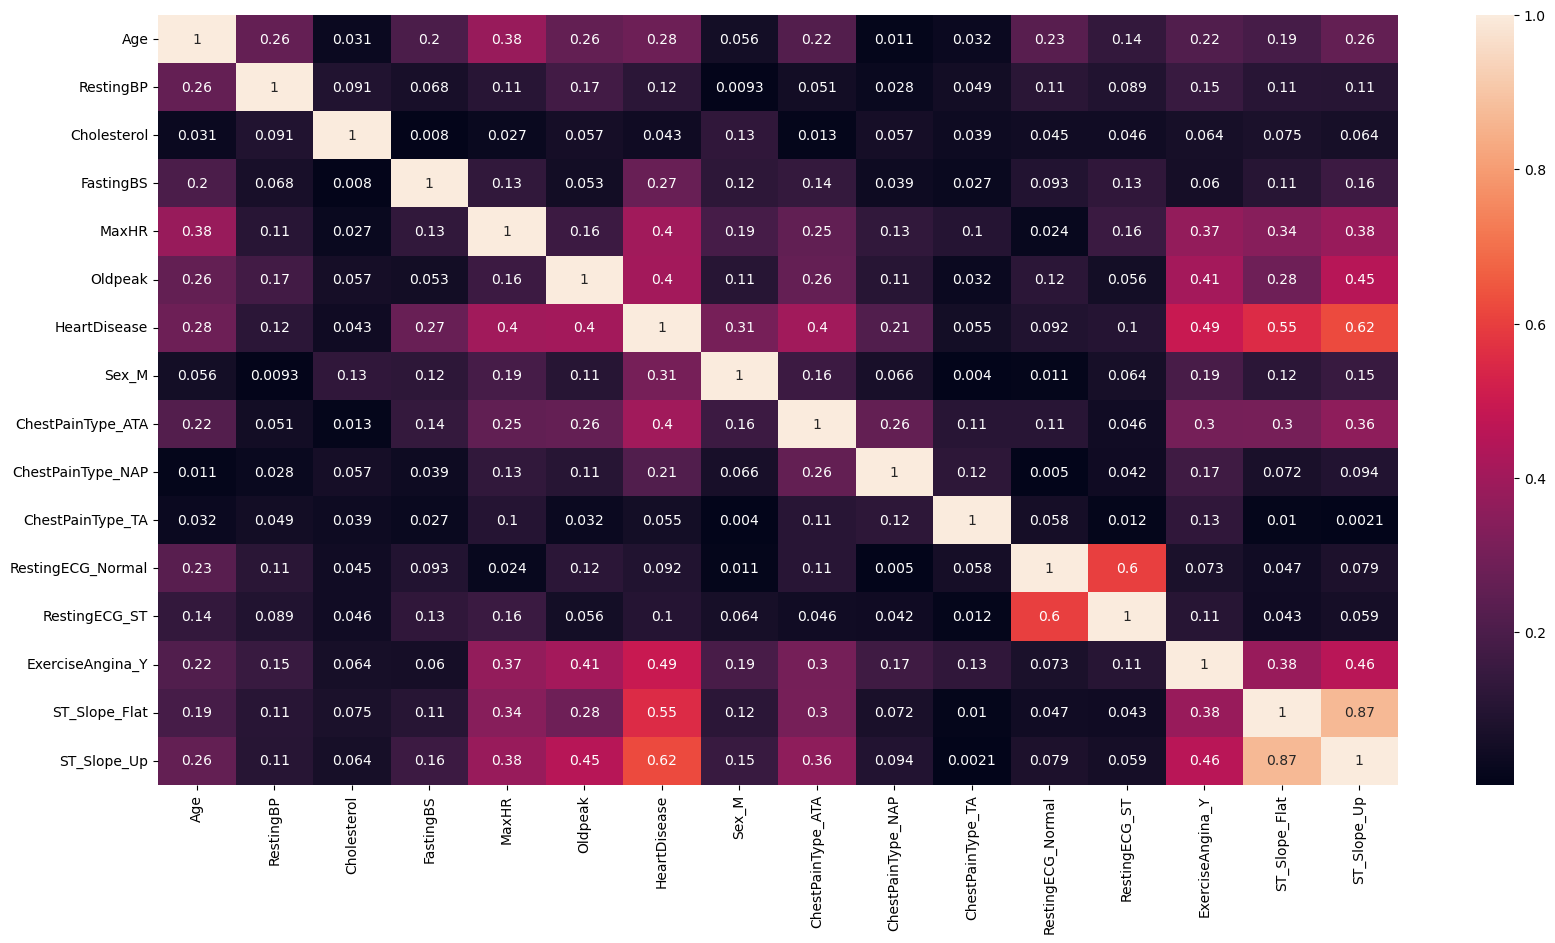

In [26]:
plt.figure(figsize = (20, 10))
sns.heatmap(correlations, annot = True)
plt.xticks(rotation = 90);

## Building a Classifier I
We will arbitrarily select features with correlation of more than **`0.25`** with the target.

In [27]:
select_features = correlations.loc[:, 'HeartDisease'].sort_values(ascending = False)
select_features

HeartDisease         1.000000
ST_Slope_Up          0.622164
ST_Slope_Flat        0.554134
ExerciseAngina_Y     0.494282
Oldpeak              0.403951
ChestPainType_ATA    0.401924
MaxHR                0.400421
Sex_M                0.305445
Age                  0.282039
FastingBS            0.267291
ChestPainType_NAP    0.212964
RestingBP            0.117798
RestingECG_ST        0.102527
RestingECG_Normal    0.091580
ChestPainType_TA     0.054790
Cholesterol          0.042988
Name: HeartDisease, dtype: float64

In [28]:
selected_cols = select_features[select_features.values > 0.25].index
selected_cols

Index(['HeartDisease', 'ST_Slope_Up', 'ST_Slope_Flat', 'ExerciseAngina_Y',
       'Oldpeak', 'ChestPainType_ATA', 'MaxHR', 'Sex_M', 'Age', 'FastingBS'],
      dtype='object')

In [29]:
select_df = df.loc[:, selected_cols]
select_df.head()

,HeartDisease,ST_Slope_Up,ST_Slope_Flat,ExerciseAngina_Y,Oldpeak,ChestPainType_ATA,MaxHR,Sex_M,Age,FastingBS
0,0,True,False,False,0.0,True,172,True,40,0
1,1,False,True,False,1.0,False,156,False,49,0
2,0,True,False,False,0.0,True,98,True,37,0
3,1,False,True,True,1.5,False,108,False,48,0
4,0,True,False,False,0.0,False,122,True,54,0


## Train - Test split

In [30]:
X = select_df.drop('HeartDisease', axis = 1)
y = select_df.HeartDisease

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 417)

### Min - Max Scaling
Computers and machine learning algorithms treat larger numbers as having higher values than smaller numbers. This is sometimes not necessarily the case, especially when a feature is measured using very large range. This holds true for any pair of features in out dataset with different scale and range of measurement. In order to address this, we can normalize our features by rescaling their values to a specific range for example using **min-max** scaling.

$$x_{scaled} = \frac{x - min(x)}{max(x) - min(x)}$$

In [31]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Hyperparameter Selection - Grid Search
**`GridSearchCV`** allows us to input a **dictionary of hyperparameters and the values** we want to search. Additionally, **`GridSearchCV`** automatically evaluates the different models on **validation sets it creates** from the training data.

In [32]:
params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
              'weights': ['uniform', 'distance'],
              'p': [2, 3, 4, 5]
             }

knn = KNeighborsClassifier()
gs_model = GridSearchCV(estimator = knn, param_grid = params, scoring = 'accuracy')
gs_model.fit(X_train_scaled, y_train)
best_score = gs_model.best_score_
best_params = gs_model.best_params_

In [33]:
print(best_score)
print(best_params)

0.8542167551952288
{'n_neighbors': 7, 'p': 5, 'weights': 'uniform'}


## Evaluating the Model on Test Set

In [34]:
accuracy = gs_model.best_estimator_.score(X_test_scaled, y_test)
print(accuracy)

0.8315217391304348


## Building a Classifier II
### Feature Selection using PCA
Let's get PCA to generate **5 features** out of the **15 features** (after generating the dummies features). There is always a trade-off in efficiency or whatever evaluation metrics because PCA always involves some loss in information. However, the gain in computation speed might be worth it...

In [35]:
X = df.drop('HeartDisease', axis = 1)
y = df.HeartDisease

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 417)

In [36]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
print(f'Number of features before PCA: {len(list(X))}')

Number of features before PCA: 15


In [38]:
pca = PCA(n_components = 5, svd_solver = 'full')
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [39]:
knn = KNeighborsClassifier(n_neighbors = 7, p = 5, weights = 'uniform')
knn.fit(X_train_pca, y_train)
acc_pca = knn.score(X_test_pca, y_test)
print(acc_pca)

0.8913043478260869


### Conclusions
* The final model accuracy (without PCA) is **83%** using **`7`** neighbours
* The model can be improved by collecting more data and probably more balanced data


* The training accuracy for this model is higher than the test accuracy. Had it been it were the reverse, it would be a sign of **underfitting. Undefitting** occurs when during training the model did not learn much. The result is that both training and testing accuracy would be poor. For KNN using too many neighbours would lead to underfitiing. On the other hand, **overfitting** occurs when the model learns more than just the pattern in the data, it also learns some noise. When tested with new data (without the noise) it would perform poorly! In KNN overfitting occurs when we train using too few neighbours. The goal is therefore to find the "sweet" or optimal k value during training.


* With 83% accuracy, this model is probably not ready to go to production. The error rate (False Positive and False Negative Rates) is too high. However, depending on the application, it's still better than no model.

* With **Principal Component Analysis (PCA)** we have reduced the number of features by almost **70%** with a test accuracy of **`89%`!!**. An improvement in both accuracy and computational speed!!

* It's worth noting that using Pearson Correlation to select features, we failed to capture any non-linear relationships between features and target (Pearson Correlation captures only linear relationship). However, PCA tries to capture any relationship that exists between features. And most importantly, **PCA takes care of (eliminates) any collinearity between features (predictors)**, which Pearson Correlation do not consider. This accounts for the improvement in the test accuracy.